In [2]:
import pandas as pd
from tqdm import tqdm
from serenityff.charge.tree.dash_tree import DASHTree
from rdkit import Chem
import torch
from custom_featurization_stuff import get_graph_from_mol
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

allowable_set= ["C","N","O","F","P","S","Cl","Br","I","H"]

In [12]:

# Function to read SDF file and extract properties
def read_sdf(file_path,prop_name,conditions = None):
    try:
        suppl = Chem.SDMolSupplier(file_path)
        data = []
        for mol in suppl:
            if mol is not None:
                smiles = Chem.MolToSmiles(mol)
                prop_val = mol.GetProp(f'{prop_name}') if mol.HasProp(f'{prop_name}') else None
                data.append({'SMILES': smiles, prop_name: prop_val})
        return data
    except OSError:
        print(f'Error reading {file_path}')
        return None

# File paths for your SDF files
vp_path = 'OPERA_Data/VP_QR.sdf'
logp_path = 'OPERA_Data/LogP_QR.sdf'
aoh_path = 'OPERA_Data/AOH_QR.sdf'
bcf_path = 'OPERA_Data/BCF_QR.sdf'
biodeg_path = 'OPERA_Data/Biodeg_QR.sdf'
BP_path = 'OPERA_Data/BP_QR.sdf'
CATMOS_path = 'OPERA_Data/CATMoS_QR50k.sdf'
CERAPP_path = 'OPERA_Data/CERAPP_QR.sdf'
Clint_path = 'OPERA_Data/Clint_QR.sdf'
CoMPARA_path = 'OPERA_Data/CoMPARA_QR.sdf'
FU_path = 'OPERA_Data/FU_QR.sdf'
HL_path = 'OPERA_Data/HL_QR.sdf'
KM_path = 'OPERA_Data/KM_QR.sdf'
KOA_path = 'OPERA_Data/KOA_QR.sdf'
KOC_path = 'OPERA_Data/KOC_QR.sdf'
MP_path = 'OPERA_Data/MP_QR.sdf'
pKA_path = 'OPERA_Data/pKa_QR.sdf'
RBiodeg_path = 'OPERA_Data/RBiodeg_QR.sdf'
RT_path = 'OPERA_Data/RT_QR.sdf'
TR_path = 'OPERA_Data/TR_QR.sdf'
WS_path = 'OPERA_Data/WS_QR.sdf'


# Read SDF files and extract data
data_vp = read_sdf(vp_path, 'LogVP')
data_logp = read_sdf(logp_path, 'logP')
data_aoh = read_sdf(aoh_path, 'logOH')
data_bcf = read_sdf(bcf_path, 'logBCF')
data_biodeg = read_sdf(biodeg_path, 'Biodeg')
data_BP = read_sdf(BP_path, 'BP')
data_CATMOS = read_sdf(CATMOS_path, 'CATMOS')
data_CERAPP = read_sdf(CERAPP_path, 'CERAPP')
data_Clint = read_sdf(Clint_path, 'Clint')
data_CoMPARA = read_sdf(CoMPARA_path, 'CoMPARA')
data_FU = read_sdf(FU_path, 'FU')
data_HL = read_sdf(HL_path, 'HL')
data_KM = read_sdf(KM_path, 'KM')
data_KOA = read_sdf(KOA_path, 'KOA')
data_KOC = read_sdf(KOC_path, 'KOC')
data_MP = read_sdf(MP_path, 'MP')
data_pKA = read_sdf(pKA_path, 'pKa')
data_RBiodeg = read_sdf(RBiodeg_path, 'RBiodeg')
data_RT = read_sdf(RT_path, 'RT')
data_WS = read_sdf(WS_path, 'WS')

# Create Pandas dataframes
df_vp = pd.DataFrame(data_vp)
df_logp = pd.DataFrame(data_logp)
df_aoh = pd.DataFrame(data_aoh)
df_bcf = pd.DataFrame(data_bcf)
df_biodeg = pd.DataFrame(data_biodeg)
df_BP = pd.DataFrame(data_BP)
df_CATMOS = pd.DataFrame(data_CATMOS)
df_CERAPP = pd.DataFrame(data_CERAPP)
df_Clint = pd.DataFrame(data_Clint)
df_CoMPARA = pd.DataFrame(data_CoMPARA)
df_FU = pd.DataFrame(data_FU)
df_HL = pd.DataFrame(data_HL)
df_KM = pd.DataFrame(data_KM)
df_KOA = pd.DataFrame(data_KOA)
df_KOC = pd.DataFrame(data_KOC)
df_MP = pd.DataFrame(data_MP)
df_pKA = pd.DataFrame(data_pKA)
df_RBiodeg = pd.DataFrame(data_RBiodeg)
df_RT = pd.DataFrame(data_RT)
df_WS = pd.DataFrame(data_WS)

# Get the smiles for all dataframes
smiles_vp = df_vp['SMILES'].tolist()
smiles_logp = df_logp['SMILES'].tolist()
smiles_aoh = df_aoh['SMILES'].tolist()
smiles_bcf = df_bcf['SMILES'].tolist()
smiles_biodeg = df_biodeg['SMILES'].tolist()
smiles_BP = df_BP['SMILES'].tolist()
smiles_CATMOS = df_CATMOS['SMILES'].tolist()
smiles_CERAPP = df_CERAPP['SMILES'].tolist()
smiles_Clint = df_Clint['SMILES'].tolist()
smiles_CoMPARA = df_CoMPARA['SMILES'].tolist()
smiles_FU = df_FU['SMILES'].tolist()
smiles_HL = df_HL['SMILES'].tolist()
smiles_KM = df_KM['SMILES'].tolist()
smiles_KOA = df_KOA['SMILES'].tolist()
smiles_KOC = df_KOC['SMILES'].tolist()
smiles_MP = df_MP['SMILES'].tolist()
smiles_pKA = df_pKA['SMILES'].tolist()
smiles_RBiodeg = df_RBiodeg['SMILES'].tolist()
smiles_RT = df_RT['SMILES'].tolist()
smiles_WS = df_WS['SMILES'].tolist()

# Get combined smiles
smiles_all = smiles_vp + smiles_logp + smiles_aoh + smiles_bcf + smiles_biodeg + smiles_BP + smiles_CATMOS + smiles_CERAPP + smiles_Clint + smiles_CoMPARA + smiles_FU + smiles_HL + smiles_KM + smiles_KOA + smiles_KOC + smiles_MP + smiles_pKA + smiles_RBiodeg + smiles_RT + smiles_WS
smiles_all = [s for s in smiles_all if s is not None]
smiles_all = list(set(smiles_all))

# For each smile in overlap, get the logP from df2 and the logVP from df1
logP = []
logVP = []
logOH = []
logBCF = []
Biodeg = []
BP = []
CATMOS = []
CERAPP = []
Clint = []
CoMPARA = []
FU = []
HL = []
KM = []
KOA = []
KOC = []
MP = []
pKA = []
RBiodeg = []
RT = []
WS = []

for smile in smiles_all:
    # Append val or 0.0 if not found
    logP.append(df_logp[df_logp['SMILES'] == smile]['logP'].values[0] if smile in smiles_logp else 0.0)
    logVP.append(df_vp[df_vp['SMILES'] == smile]['logVP'].values[0] if smile in smiles_vp else 0.0)
    logOH.append(df_aoh[df_aoh['SMILES'] == smile]['logOH'].values[0] if smile in smiles_aoh else 0.0)
    logBCF.append(df_bcf[df_bcf['SMILES'] == smile]['logBCF'].values[0] if smile in smiles_bcf else 0.0)
    Biodeg.append(df_biodeg[df_biodeg['SMILES'] == smile]['Biodeg'].values[0] if smile in smiles_biodeg else 0.0)
    BP.append(df_BP[df_BP['SMILES'] == smile]['BP'].values[0] if smile in smiles_BP else 0.0)
    CATMOS.append(df_CATMOS[df_CATMOS['SMILES'] == smile]['CATMOS'].values[0] if smile in smiles_CATMOS else 0.0)
    CERAPP.append(df_CERAPP[df_CERAPP['SMILES'] == smile]['CERAPP'].values[0] if smile in smiles_CERAPP else 0.0)
    Clint.append(df_Clint[df_Clint['SMILES'] == smile]['Clint'].values[0] if smile in smiles_Clint else 0.0)
    CoMPARA.append(df_CoMPARA[df_CoMPARA['SMILES'] == smile]['CoMPARA'].values[0] if smile in smiles_CoMPARA else 0.0)
    FU.append(df_FU[df_FU['SMILES'] == smile]['FU'].values[0] if smile in smiles_FU else 0.0)
    HL.append(df_HL[df_HL['SMILES'] == smile]['HL'].values[0] if smile in smiles_HL else 0.0)
    KM.append(df_KM[df_KM['SMILES'] == smile]['KM'].values[0] if smile in smiles_KM else 0.0)
    KOA.append(df_KOA[df_KOA['SMILES'] == smile]['KOA'].values[0] if smile in smiles_KOA else 0.0)
    KOC.append(df_KOC[df_KOC['SMILES'] == smile]['KOC'].values[0] if smile in smiles_KOC else 0.0)
    MP.append(df_MP[df_MP['SMILES'] == smile]['MP'].values[0] if smile in smiles_MP else 0.0)
    pKA.append(df_pKA[df_pKA['SMILES'] == smile]['pKa'].values[0] if smile in smiles_pKA else 0.0)
    RBiodeg.append(df_RBiodeg[df_RBiodeg['SMILES'] == smile]['RBiodeg'].values[0] if smile in smiles_RBiodeg else 0.0)
    RT.append(df_RT[df_RT['SMILES'] == smile]['RT'].values[0] if smile in smiles_RT else 0.0)
    WS.append(df_WS[df_WS['SMILES'] == smile]['WS'].values[0] if smile in smiles_WS else 0.0)

# Make a new dataframe
df = pd.DataFrame({'SMILES': smiles_all, 'logP': logP, 'logVP': logVP, 'logOH': logOH, 'logBCF': logBCF, 'Biodeg': Biodeg, 'BP': BP, 'CATMOS': CATMOS, 'CERAPP': CERAPP, 'Clint': Clint, 'CoMPARA': CoMPARA, 'FU': FU, 'HL': HL, 'KM': KM, 'KOA': KOA, 'KOC': KOC, 'MP': MP, 'pKA': pKA, 'RBiodeg': RBiodeg, 'RT': RT, 'WS': WS})
df


# # Create Pandas dataframes
# df_vp = pd.DataFrame(data_vp)
# df_logp = pd.DataFrame(data_logp)

# #get the smiles for both
# smiles_vp = df_vp['SMILES'].tolist()
# smiles_logp = df_logp['SMILES'].tolist()
# #get combined smiles
# smiles_all = smiles_vp + smiles_logp
# smiles_all = [s for s in smiles_all if s is not None]
# smiles_all = list(set(smiles_all))
# #foreach smile in overlap, get the logP from df2 and the logVP from df1
# logP = []
# logVP = []
# for smile in smiles_all:
#     #append val or 0.0 if not found
#     logP.append(df_logp[df_logp['SMILES'] == smile]['logP'].values[0] if smile in smiles_logp else 0.0)
#     logVP.append(df_vp[df_vp['SMILES'] == smile]['logVP'].values[0] if smile in smiles_vp else 0.0)
    
# #make a new dataframe
# df = pd.DataFrame({'SMILES': smiles_all, 'logP': logP, 'logVP': logVP})
# df



[09:44:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:44:20] ERROR: Could not sanitize molecule ending on line 38202
[09:44:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:44:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:44:22] ERROR: Could not sanitize molecule ending on line 5019
[09:44:22] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:44:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 10 11 12 13 14 15 16
[09:44:23] ERROR: Could not sanitize molecule ending on line 786943
[09:44:23] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 10 11 12 13 14 15 16
[09:44:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 11 12 13 14 15 16 22 23
[09:44:24] ERROR: Could not sanitize molecule ending on line 1003777
[09:44:24] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 11 12 13 14 15 16 22 23
[09:44:24] Can't kekulize mo

,SMILES,logP,logVP,logOH,logBCF,Biodeg,BP,CATMOS,CERAPP,Clint,...,FU,HL,KM,KOA,KOC,MP,pKA,RBiodeg,RT,WS
0,O=C(c1ccccc1)c1ccc([O-])[n+](O)c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
1,CC1=CC(=O)C=C(C)C1=O,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,72.5,0.0,0.0,0.0,0.0
2,CC1C=NC(=O)N=C1N,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
3,O=c1ccn(C2OC(CO)CC2O)c(=O)[nH]1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCN(CCC#N)c1ccc(C=O)c(C)c1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75500,CCCCC(CC)COC(=O)NS(N)(=O)=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
75501,NC1CCc2ccccc21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
75502,CCC1CO1,0.0,NaN,NaN,0.0,0.0,63.3,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
75503,FC(F)(I)C(F)(F)I,0.0,0.0,0.0,0.0,0.0,112.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df
#print the sum of each column (expect first)
for col in df.columns[1:]:
    try:
        print(f'{col}: {df[col].sum()}')
    except TypeError:
        print(col)

logP: 0.0
logVP: 0.0
logOH: 0.0
logBCF: 0.0
Biodeg: 0.0
BP
CATMOS: 0.0
CERAPP: 0.0
Clint
CoMPARA: 0.0
FU
HL: 0.0
KM: 0.0
KOA: 0.0
KOC: 0.0
MP
pKA: 0.0
RBiodeg: 0.0
RT
WS: 0.0


In [10]:
import pandas as pd
from rdkit import Chem

def read_and_create_dataframe(file_path, prop_name):
    try:
        suppl = Chem.SDMolSupplier(file_path)
        data = [{'SMILES': Chem.MolToSmiles(mol), prop_name: mol.GetProp(prop_name) if mol.HasProp(prop_name) else None}
                for mol in suppl if mol is not None]
        return pd.DataFrame(data)
    except OSError:
        print(f'Error reading {file_path}')
        return None

# File paths for your SDF files
file_paths = {
    'vp': 'OPERA_Data/VP_QR.sdf',
    'logp': 'OPERA_Data/LogP_QR.sdf',
    'aoh': 'OPERA_Data/AOH_QR.sdf',
    'bcf': 'OPERA_Data/BCF_QR.sdf',
    'biodeg': 'OPERA_Data/Biodeg_QR.sdf',
    'bp': 'OPERA_Data/BP_QR.sdf',
    'catmos': 'OPERA_Data/CATMoS_QR50k.sdf',
    'cerapp': 'OPERA_Data/CERAPP_QR.sdf',
    'clint': 'OPERA_Data/Clint_QR.sdf',
    'compara': 'OPERA_Data/CoMPARA_QR.sdf',
    'fu': 'OPERA_Data/FU_QR.sdf',
    'hl': 'OPERA_Data/HL_QR.sdf',
    'km': 'OPERA_Data/KM_QR.sdf',
    'koa': 'OPERA_Data/KOA_QR.sdf',
    'koc': 'OPERA_Data/KOC_QR.sdf',
    'mp': 'OPERA_Data/MP_QR.sdf',
    'pka': 'OPERA_Data/pKa_QR.sdf',
    'rbiodeg': 'OPERA_Data/RBiodeg_QR.sdf',
    'rt': 'OPERA_Data/RT_QR.sdf',
    'ws': 'OPERA_Data/WS_QR.sdf',
}

# Define property names
properties = {
    'vp': 'logVP',
    'logp': 'logP',
    'aoh': 'logOH',
    'bcf': 'logBCF',
    'biodeg': 'Biodeg',
    'bp': 'BP',
    'catmos': 'CATMOS',
    'cerapp': 'CERAPP',
    'clint': 'Clint',
    'compara': 'CoMPARA',
    'fu': 'FU',
    'hl': 'HL',
    'km': 'KM',
    'koa': 'KOA',
    'koc': 'KOC',
    'mp': 'MP',
    'pka': 'pKa',
    'rbiodeg': 'RBiodeg',
    'rt': 'RT',
    'ws': 'WS',
}

# Read SDF files and create dataframes
dataframes = {}
for key, path in file_paths.items():
    dataframes[key] = read_and_create_dataframe(path, properties[key])

# Combine SMILES from all dataframes
all_smiles = set().union(*[df['SMILES'].tolist() for df in dataframes.values()])

# Create a new dataframe with SMILES and all properties
columns = ['SMILES'] + [prop for prop_name in properties.values() for prop in [f'{prop_name}_{key}' for key in file_paths.keys()]]
new_data = {column: [] for column in columns}

for smile in all_smiles:
    new_data['SMILES'].append(smile)
    for key, df in dataframes.items():
        prop_name = properties[key]
        prop_value = df[df['SMILES'] == smile][prop_name].values[0] if smile in df['SMILES'].tolist() else 0.0
        new_data[f'{prop_name}_{key}'].append(prop_value)

df_combined = pd.DataFrame(new_data)
df_combined

[09:19:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:19:31] ERROR: Could not sanitize molecule ending on line 38202
[09:19:31] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:19:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:19:33] ERROR: Could not sanitize molecule ending on line 5019
[09:19:33] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[09:19:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 10 11 12 13 14 15 16
[09:19:35] ERROR: Could not sanitize molecule ending on line 786943
[09:19:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 10 11 12 13 14 15 16
[09:19:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 11 12 13 14 15 16 22 23
[09:19:35] ERROR: Could not sanitize molecule ending on line 1003777
[09:19:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 11 12 13 14 15 16 22 23
[09:19:35] Can't kekulize mo

ValueError: All arrays must be of the same length

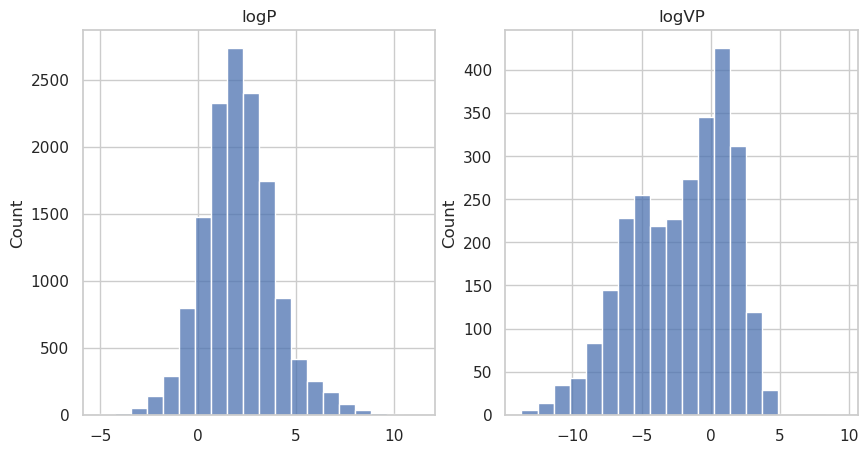

In [35]:
#do histograms of the logps and vps
logp_vals = df['logP'].tolist()
vp_vals = df['logVP'].tolist()
logp_vals = [v for v in logp_vals if v != 0.0]
vp_vals = [v for v in vp_vals if v != 0.0]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(logp_vals, ax=ax[0],bins=20)
ax[0].set_title('logP')
sns.histplot(vp_vals, ax=ax[1],bins=20)
ax[1].set_title('logVP')
plt.show()


In [11]:
tree = DASHTree(tree_folder_path='/localhome/cschiebroek/other/serenityff-charge/tree')

Loading DASH tree data


In [12]:
all_mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
mols_with_charges = []
error_mols_charges = []
for m in tqdm(mols):
    try:
        mol = Chem.AddHs(m, addCoords=True)
        charges = tree.get_molecules_partial_charges(mol,chg_std_key='std',chg_key='result')["charges"]
    except:
        error_mols_charges.append(m)
        continue
    for i,atom in enumerate(mol.GetAtoms()):
        atom.SetDoubleProp('charge',charges[i])
    mols_with_charges.append(mol)


100%|██████████| 15079/15079 [05:28<00:00, 45.88it/s]


In [13]:
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))

143 1 142


In [15]:
if indices_to_drop_total:
    print('Caution! Mols dropped')
    df = df.drop(indices_to_drop_total)

In [18]:
#set values of second two columns as floats
df['logP'] = df['logP'].astype(float)
df['logVP'] = df['logVP'].astype(float)

In [22]:
ys = df.iloc[:, -2:].values
y = torch.tensor(ys, dtype=torch.float32)
y = y.unsqueeze(1)

In [25]:
y[0]

tensor([[ 0.0000, -1.3979]])

In [23]:
assert len(mols_with_charges) == len(y)
data = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols_with_charges)]
for i in range(len(data)):
    data[i].y = y[i]

CustomData(x=[39, 24], edge_index=[2, 78], edge_attr=[78, 11], y=[39], batch=[39], molecule_charge=[1], smiles='[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]', sdf_idx=0)


In [26]:
#basics
import os
from math import sqrt
import pandas
import numpy as np
import random


#torch stuff
import torch
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.loader import DataLoader



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

def train_multi(train_loader, model, optimizer, device, outputs):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != 0.0).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)

        weighted_loss = weighted_loss / num_labels
        weighted_loss.backward()

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs

        # clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        del data

    return sqrt(total_loss / total_examples)


def validate_multi(val_loader, model, outputs):
    total_loss = total_examples = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):

            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != 0.0).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)

        weighted_loss = weighted_loss / num_labels

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs
        del data

    return sqrt(total_loss / total_examples)

def train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs, outputs, verbose=True):
    train_losses = []
    val_losses = []
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)

    min_val_los = 1000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_multi(train_loader, model, optimizer, device, outputs)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_multi(val_loader, model, outputs)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
            torch.save(model.state_dict(), 'test_model.pt')

        else:
            counter += 1
        if counter > 10:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [29]:

torch.cuda.empty_cache()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
#split train in train and val
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)
# #datloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=2,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=2, verbose=True)

Epoch 1/100: Train Loss: 1.5453, Val Loss: 1.0815
Epoch 2/100: Train Loss: 1.0209, Val Loss: 0.9635
Epoch 3/100: Train Loss: 0.8893, Val Loss: 0.8559
Epoch 4/100: Train Loss: 0.8236, Val Loss: 0.8044
Epoch 5/100: Train Loss: 0.7990, Val Loss: 0.8357
Epoch 6/100: Train Loss: 0.7630, Val Loss: 0.7707
Epoch 7/100: Train Loss: 0.7258, Val Loss: 0.7408
Epoch 8/100: Train Loss: 0.6903, Val Loss: 0.7275
Epoch 9/100: Train Loss: 0.6593, Val Loss: 0.7081
Epoch 10/100: Train Loss: 0.6488, Val Loss: 0.7363
Epoch 11/100: Train Loss: 0.6417, Val Loss: 0.6921
Epoch 12/100: Train Loss: 0.6216, Val Loss: 0.7320
Epoch 13/100: Train Loss: 0.6229, Val Loss: 0.7218
Epoch 14/100: Train Loss: 0.5946, Val Loss: 0.6843
Epoch 15/100: Train Loss: 0.5785, Val Loss: 0.6894
Epoch 16/100: Train Loss: 0.5756, Val Loss: 0.6978
Epoch 17/100: Train Loss: 0.5671, Val Loss: 0.7185
Epoch 18/100: Train Loss: 0.5562, Val Loss: 0.6721
Epoch 19/100: Train Loss: 0.5526, Val Loss: 0.6648
Epoch 20/100: Train Loss: 0.5334, Val Lo

In [37]:
print(len(train_data), len(val_data), len(test_data))

9559 2390 2988


In [30]:
from scipy.stats import spearmanr,kendalltau
def get_preds_per_task(val_loader, model, outputs):
    preds = tuple([[] for i in range(outputs)])
    ys = tuple([[] for i in range(outputs)])
    counter = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]

            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != 0).view(-1)

            if len(present_label_indices) > 0:
                counter += len(present_label_indices)
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)
                out_tmp_present = [float(i) for i in out_tmp_present]
                y_tmp_present = [float(i) for i in y_tmp_present]
                preds[i].extend(out_tmp_present)  
                ys[i].extend(y_tmp_present)
    print(counter)
    return preds,ys


def get_stats(out_list,y_list):
    kendall_tau = kendalltau(y_list, out_list)[0]
    rmse_overall = np.sqrt(np.mean((np.array(y_list) - np.array(out_list)) ** 2))
    mae_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)))
    within_03_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 0.3)
    within_1_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 1)

    return kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall



3297
Pearson: 0.9751432300028438
R2: 0.9503248588993768
kendall_tau: 0.8661657696915188
rmse_overall: 0.4156698924446922
mae_overall: 0.2923418365560154
within_03_overall: 0.6387167335034634
within_1_overall: 0.9722931097338681
Datapoints: 2743


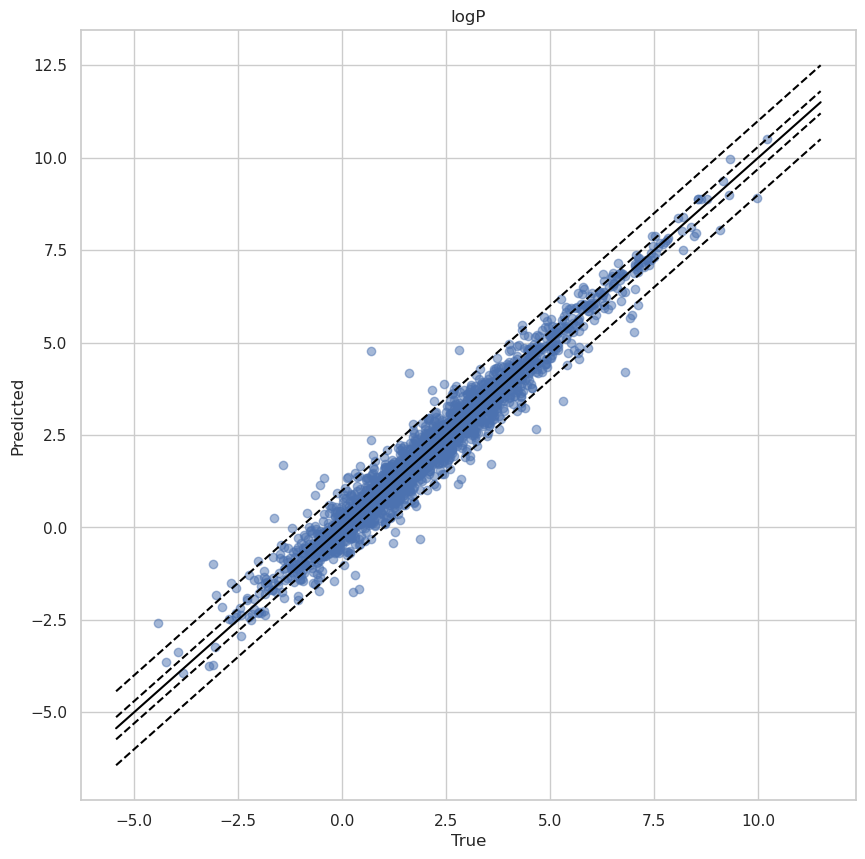

Pearson: 0.9670384096215562
R2: 0.9348841406854138
kendall_tau: 0.8921488963870139
rmse_overall: 0.9175114579294034
mae_overall: 0.548278686878379
within_03_overall: 0.5252707581227437
within_1_overall: 0.8375451263537906
Datapoints: 554


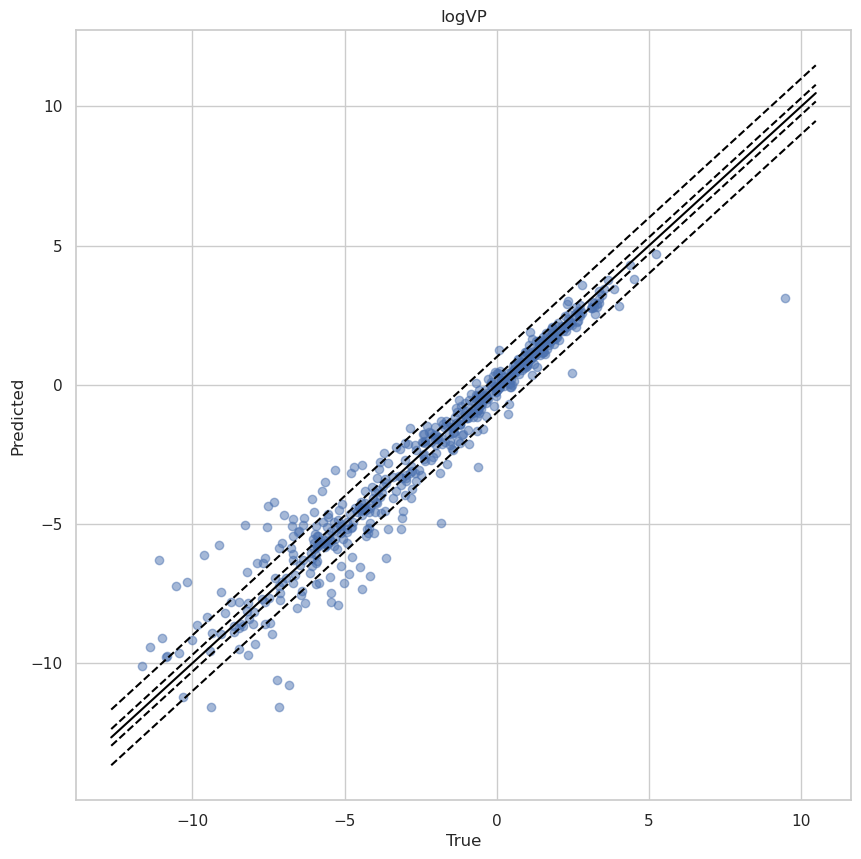

In [38]:
#not plot the outputs in same way, but for each task (colored)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
preds,ys = get_preds_per_task(test_loader, model, 2)
#get the names of the columns
column_names = df.columns[-2:]

for i in range(2):
    kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds[i],ys[i])
    r2 = r2_score(ys[i],preds[i])
    pearson = pearsonr(ys[i],preds[i]).statistic
    print('Pearson:',pearson)
    print('R2:',r2)
    plt.figure(figsize=(10, 10))
    plt.scatter(ys[i], preds[i], alpha=0.5)
    min_val = min(min(ys[i]),min(preds[i]))
    max_val = max(max(ys[i]),max(preds[i]))
    #add diagonal, and lines at +- 0.3 and +- 1
    plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
    plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(column_names[i])
    print(f'kendall_tau: {kendall_tau}')
    print(f'rmse_overall: {rmse_overall}')
    print(f'mae_overall: {mae_overall}')
    print(f'within_03_overall: {within_03_overall}')
    print(f'within_1_overall: {within_1_overall}')
    print(f'Datapoints: {len(ys[i])}')
    plt.show()


To do:
1. Add the different endpoints - check
2. Normalization of values
3. Weighting of the tasks
4. Hyperparameter optimization
5. Benchmarking datasets? E.g. SAMPL7 for logP
6. Quadruple check refs - check
7. Think about datasplitting: same splits as OPERA? possible? otherwise, just cross-val? or random splits (multiple)
8. Different random weight initializations of the model


split: 80/20 5x

HP OPT: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html
Repeated K-fold: https://greglandrum.github.io/rdkit-blog/posts/2023-08-13-xval-variability1.html